<a href="https://colab.research.google.com/github/crystal0523/Instance-segmentation-using-Detectron2/blob/main/instance_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
#install packages
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install detectron2==0.1.3 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
     |████████████████████████████████| 703.8MB 24kB/s 
     |████████████████████████████████| 6.6MB 66.1MB/s 
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101
  Found existing installation: torchvision 0.8.1+cu101
    Uninstalling torchvision-0.8.1+cu101:
      Successfully uninstalled torchvision-0.8.1+cu101


     |████████████████████████████████| 276kB 12.7MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp36-cp36m-linux_x86_64.whl size=44075 sha256=38f04204f1d02161400487062a1fbb36f7de00d59322180c57c1f84e6e719444
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-o5gziugc
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-o5gziugc
  Created wheel for pycocotools: filename=pycocotools-2.0-cp36-cp36m-linux_x86_64.whl size=266463 sha256=5162096f4ea6ce4320defd8605d609df41d7574c3aca29f008861485ef0723e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-w93_op4e/wheels/90/51/41/646daf401c3bc408ff10de34ec76587a9b3ebfac8d21ca5c3a
Successfully built pycocotools
  Found existing instal

In [3]:
import torch, torchvision
import detectron2
from detectron2.utils.logger import setup_logger
import os
import numpy as np
import json
import cv2
import pandas as pd
import random
from detectron2.structures import BoxMode
from detectron2.engine import DefaultPredictor, DefaultTrainer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer

setup_logger()

import itertools
from itertools import groupby
from google.colab.patches import cv2_imshow

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskutil
from pycocotools import mask as maskUtils
print(torch.__version__, torch.cuda.is_available())
setup_logger()

ModuleNotFoundError: ignored

In [3]:
# register training and test datasets to Detectron2
DatasetCatalog.clear()
register_coco_instances("train_pascal", {}, "/content/drive/My Drive/pascal_train.json", "/content/drive/My Drive/train_images")
register_coco_instances("test", {}, "/content/drive/My Drive/test.json", "/content/drive/My Drive/test_images")

# metadata
train_metadata = MetadataCatalog.get("train_pascal")
test_metadata = MetadataCatalog.get("test")

# dataset dictionary
train_dataset_dicts = DatasetCatalog.get("train_pascal")
test_dataset_dicts = DatasetCatalog.get("test")

[12/03 05:41:08 d2.data.datasets.coco]: Loading /content/drive/My Drive/pascal_train.json takes 2.10 seconds.
[12/03 05:41:08 d2.data.datasets.coco]: Loaded 1349 images in COCO format from /content/drive/My Drive/pascal_train.json
[12/03 05:41:09 d2.data.datasets.coco]: Loaded 100 images in COCO format from /content/drive/My Drive/test.json


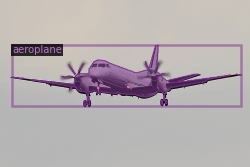

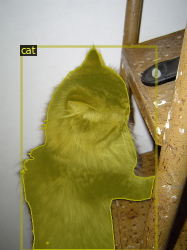

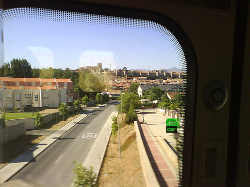

In [4]:
#show image
for d in random.sample(train_dataset_dicts, 3):
    image = cv2.imread(d["file_name"])
    visualizer = Visualizer(image[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [10]:
from detectron2 import model_zoo
cfg = get_cfg()

# load ImageNet pretrained weights

cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
# load dataset
cfg.DATASETS.TRAIN = ("train_pascal",)

# parameters
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 20000                    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 20  
cfg.OUTPUT_DIR = "/content/drive/My Drive/output"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()     


[12/03 06:03:59 d2.utils.events]:  eta: 2:39:11  iter: 19  total_loss: 4.316  loss_cls: 2.890  loss_box_reg: 0.002  loss_mask: 0.693  loss_rpn_cls: 0.670  loss_rpn_loc: 0.018  time: 0.4789  data_time: 0.0243  lr: 0.000005  max_mem: 3232M
[12/03 06:04:09 d2.utils.events]:  eta: 2:39:32  iter: 39  total_loss: 3.137  loss_cls: 1.745  loss_box_reg: 0.002  loss_mask: 0.694  loss_rpn_cls: 0.662  loss_rpn_loc: 0.026  time: 0.4879  data_time: 0.0081  lr: 0.000010  max_mem: 3353M
[12/03 06:04:19 d2.utils.events]:  eta: 2:39:28  iter: 59  total_loss: 1.837  loss_cls: 0.428  loss_box_reg: 0.008  loss_mask: 0.693  loss_rpn_cls: 0.647  loss_rpn_loc: 0.032  time: 0.4870  data_time: 0.0064  lr: 0.000015  max_mem: 3353M
[12/03 06:04:28 d2.utils.events]:  eta: 2:38:42  iter: 79  total_loss: 1.540  loss_cls: 0.180  loss_box_reg: 0.002  loss_mask: 0.693  loss_rpn_cls: 0.629  loss_rpn_loc: 0.017  time: 0.4804  data_time: 0.0054  lr: 0.000020  max_mem: 3353M
[12/03 06:04:38 d2.utils.events]:  eta: 2:38:38 

KeyError: ignored

In [12]:
cfg.OUTPUT_DIR = "/content/drive/My Drive/output"
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_0019999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("test", )
coco = COCO('/content/drive/My Drive/pascal_train.json') 

# save categories
CLASS_NAMES = [coco.cats[k]['name'] for k in coco.cats.keys()]

# metadata
test_metadata.set(thing_classes=CLASS_NAMES)

# define predictor
predictor = DefaultPredictor(cfg)

loading annotations into memory...
Done (t=0.25s)
creating index...
index created!


In [1]:
def binary_mask_to_rle(binary_mask):
    rle = {'counts': [], 'size': list(binary_mask.shape)}
    counts = rle.get('counts')
    for i, (value, elements) in enumerate(groupby(binary_mask.ravel(order='F'))):
        if i == 0 and value == 1:
            counts.append(0)
        counts.append(len(list(elements)))
    compressed_rle = maskutil.frPyObjects(rle, rle.get('size')[0], rle.get('size')[1])
    compressed_rle['counts'] = str(compressed_rle['counts'], encoding='utf-8')
    return compressed_rle

# load test annotations
cocoGt = COCO("/content/drive/My Drive/test.json")

# store results
coco_dt = []

for imgid in cocoGt.imgs:
    # read test image
    image = cv2.imread("/content/drive/My Drive/test_images/" + cocoGt.loadImgs(ids=imgid)[0]['file_name'])[:,:,::-1]

    # make prediction
    outputs = predictor(image)

    # parse prediction
    boxes = (outputs['instances']._fields['pred_boxes'].tensor).cpu().numpy()
    scores = (outputs['instances']._fields['scores']).cpu().numpy()
    categories = (outputs['instances']._fields['pred_classes']).cpu().numpy()
    masks = (outputs['instances']._fields['pred_masks']).cpu().numpy()
    n_instances = len(scores)
    if len(categories) > 0:
        for i in range(n_instances):
            pred = {}
            pred['image_id'] = imgid
            pred['score'] = float(scores[i])
            pred['category_id'] = int(categories[i]) + 1
            pred['segmentation'] = binary_mask_to_rle(masks[i,:,:])
            
            coco_dt.append(pred)
with open('309551053.json', 'w') as f:
    f.write(pd.Series(coco_dt).to_json(orient='values'))
f.close()

NameError: ignored

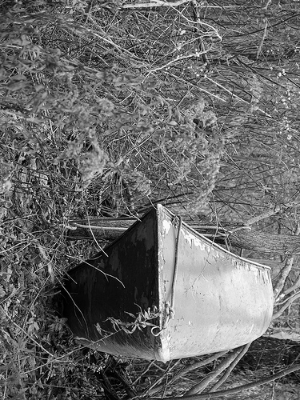

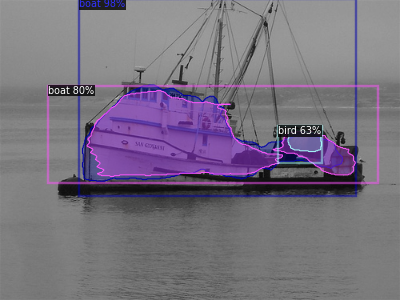

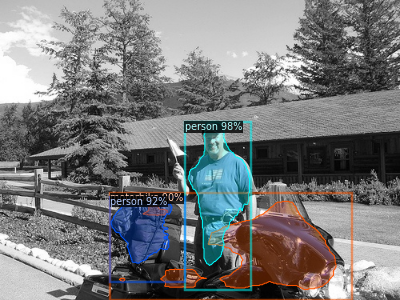

In [17]:
cfg.MODEL.WEIGHTS = '/content/drive/My Drive/output/model_0019999.pth'
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
cfg.DATASETS.TEST = ("test")
predictor = DefaultPredictor(cfg)

from detectron2.utils.visualizer import ColorMode

for d in random.sample(test_dataset_dicts, 3):    
    image = cv2.imread(d["file_name"])
    outputs = predictor(image)
    v = Visualizer(image[:, :, ::-1],
                   metadata=test_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW  
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])